Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [3]:
!pip install -q numpy pandas matplotlib seaborn 
!pip install -q torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import time
import os
import pickle
import importlib
import pandas as pd



### Helper Functions - Save and Load Models

In [4]:
# Utility functions for saving and loading models
# will use to cache experiments to avoid retraining models and to allow reproducible results
def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [ ]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
best_batch_size = 32
train_loader = DataLoader(train_dataset_normalized, batch_size=best_batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(val_dataset_normalized, batch_size=best_batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset_normalized, batch_size=best_batch_size, shuffle=False, generator=generator)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.2860405743122101, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


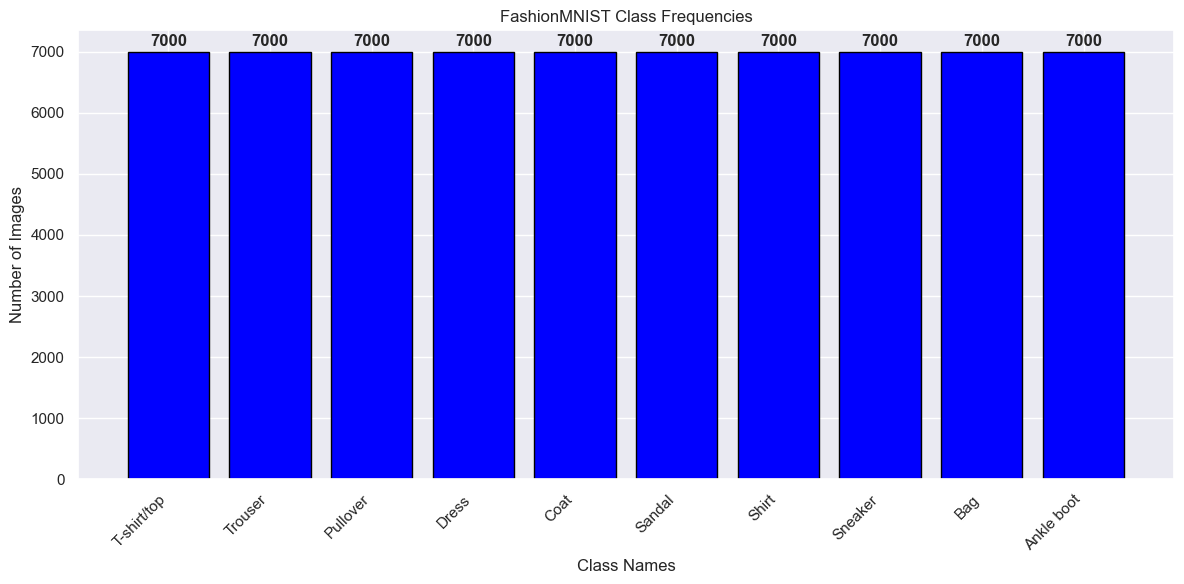

In [16]:
# Explore what classes of the dataset
class_names = full_train_dataset_normalized.classes
print(class_names)

all_labels = torch.cat([full_train_dataset_normalized.targets, test_dataset_normalized.targets])
unique, counts = np.unique(all_labels.numpy(), return_counts=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, counts, color='blue', edgecolor='black')
plt.title('FashionMNIST Class Frequencies')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, counts): 
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Task 2: Implement a Multilayer Perceptron

In [17]:
import mlp                # only required if not already imported
importlib.reload(mlp)     # reloads the module from disk
from mlp import MLP, softmax, evaluate_acc  # rebinds names in notebook namespace

import activation_functions
importlib.reload(activation_functions)  # reloads the module from disk
from activation_functions import relu, leakyRelu, sigmoid, tanh  # rebinds names in notebook namespace

# Task 3: Run the experiments and report

## 3.0: Hyperparameter Tuning

### Learning Rate

In [36]:
# comparison of learning rates using a sset batch size of 64
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

accuracies = {
    "Learning Rate": [],
    "Validation Accuracy": []
}

for lr in lrs:
    model = load_model(f'model_lr_{lr}')

    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit_validation(train_loader, validation_loader, learning_rate=lr, epochs=20)
        save_model(model, f'model_lr_{lr}')    
    
    val_accuracy = model.val_accuracy_history[-1]

    accuracies["Learning Rate"].append(lr)
    accuracies["Validation Accuracy"].append(val_accuracy)

# table comparison of learning rates
df = pd.DataFrame(accuracies)
print(df)

No saved model found at saved_models\model_lr_0.001.pkl
Epoch 1/20, Validation Accuracy: 0.7298
Epoch 2/20, Validation Accuracy: 0.7675
Epoch 3/20, Validation Accuracy: 0.7884
Epoch 4/20, Validation Accuracy: 0.8024
Epoch 5/20, Validation Accuracy: 0.8103
Epoch 6/20, Validation Accuracy: 0.8166
Epoch 7/20, Validation Accuracy: 0.8237
Epoch 8/20, Validation Accuracy: 0.8288
Epoch 9/20, Validation Accuracy: 0.8304
Epoch 10/20, Validation Accuracy: 0.8343
Epoch 11/20, Validation Accuracy: 0.8373
Epoch 12/20, Validation Accuracy: 0.8383
Epoch 13/20, Validation Accuracy: 0.8417
Epoch 14/20, Validation Accuracy: 0.8447
Epoch 15/20, Validation Accuracy: 0.8457
Epoch 16/20, Validation Accuracy: 0.8482
Epoch 17/20, Validation Accuracy: 0.8494
Epoch 18/20, Validation Accuracy: 0.8505
Epoch 19/20, Validation Accuracy: 0.8515
Epoch 20/20, Validation Accuracy: 0.8497
Model saved to saved_models\model_lr_0.001.pkl
No saved model found at saved_models\model_lr_0.005.pkl
Epoch 1/20, Validation Accurac

Model loaded from saved_models\model_lr_0.001.pkl
Model loaded from saved_models\model_lr_0.005.pkl
Model loaded from saved_models\model_lr_0.01.pkl
Model loaded from saved_models\model_lr_0.05.pkl
Model loaded from saved_models\model_lr_0.1.pkl


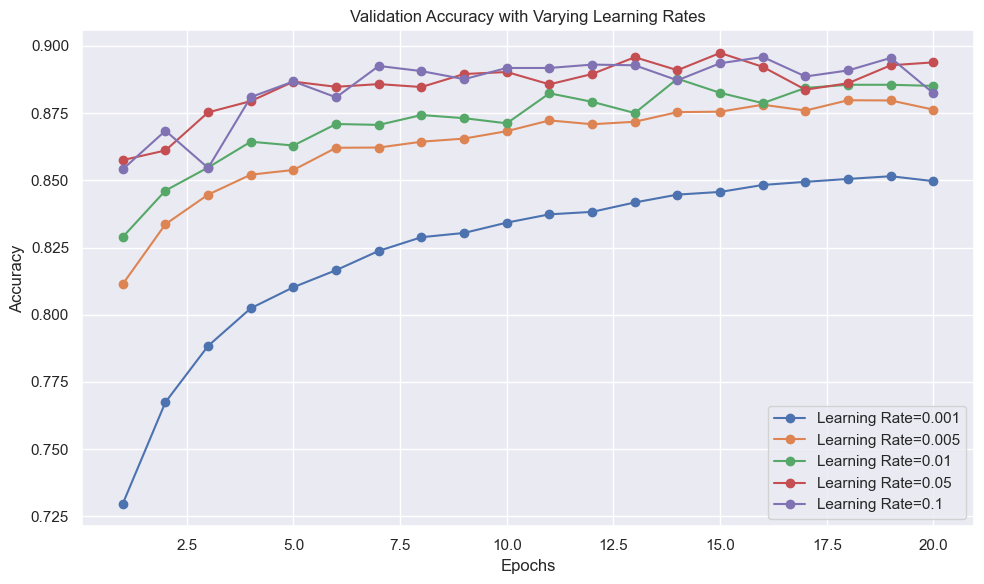

In [37]:
plt.figure(figsize=(10, 6))

for lr in lrs:
    model = load_model(f'model_lr_{lr}')
    if model is None:
        continue
    epochs = range(1, len(model.val_accuracy_history) + 1)
    plt.plot(epochs, model.val_accuracy_history, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Varying Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Batch Size

In [42]:
batch_sizes = [16, 32, 64, 128]
best_lr = 0.05

accuracies = {
    "Batch Size": [],
    "Validation Accuracy": []
}

for batch in batch_sizes:
    hyperparam_train_loader = DataLoader(train_dataset_normalized, batch_size=batch, shuffle=True, generator=generator)
    hyperparam_validation_loader = DataLoader(val_dataset_normalized, batch_size=batch, shuffle=False, generator=generator)

    model = load_model(f'model_bs_{batch}')

    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit_validation(hyperparam_train_loader, hyperparam_validation_loader, learning_rate=best_lr, epochs=20)
        save_model(model, f'model_bs_{batch}')    
    
    val_accuracy = model.val_accuracy_history[-1]

    accuracies["Batch Size"].append(batch)
    accuracies["Validation Accuracy"].append(val_accuracy)

# table comparison of learning rates
df = pd.DataFrame(accuracies)
print(df)

No saved model found at saved_models\model_bs_16.pkl
Epoch 1/20, Validation Accuracy: 0.8569
Epoch 2/20, Validation Accuracy: 0.8648
Epoch 3/20, Validation Accuracy: 0.8556
Epoch 4/20, Validation Accuracy: 0.8761
Epoch 5/20, Validation Accuracy: 0.8842
Epoch 6/20, Validation Accuracy: 0.8824
Epoch 7/20, Validation Accuracy: 0.8879
Epoch 8/20, Validation Accuracy: 0.8882
Epoch 9/20, Validation Accuracy: 0.8872
Epoch 10/20, Validation Accuracy: 0.8861
Epoch 11/20, Validation Accuracy: 0.8880
Epoch 12/20, Validation Accuracy: 0.8853
Epoch 13/20, Validation Accuracy: 0.8854
Epoch 14/20, Validation Accuracy: 0.8867
Epoch 15/20, Validation Accuracy: 0.8880
Epoch 16/20, Validation Accuracy: 0.8879
Epoch 17/20, Validation Accuracy: 0.8868
Epoch 18/20, Validation Accuracy: 0.8952
Epoch 19/20, Validation Accuracy: 0.8901
Epoch 20/20, Validation Accuracy: 0.8958
Model saved to saved_models\model_bs_16.pkl
No saved model found at saved_models\model_bs_32.pkl
Epoch 1/20, Validation Accuracy: 0.8621

Model loaded from saved_models\model_bs_16.pkl
Model loaded from saved_models\model_bs_32.pkl
Model loaded from saved_models\model_bs_64.pkl
Model loaded from saved_models\model_bs_128.pkl


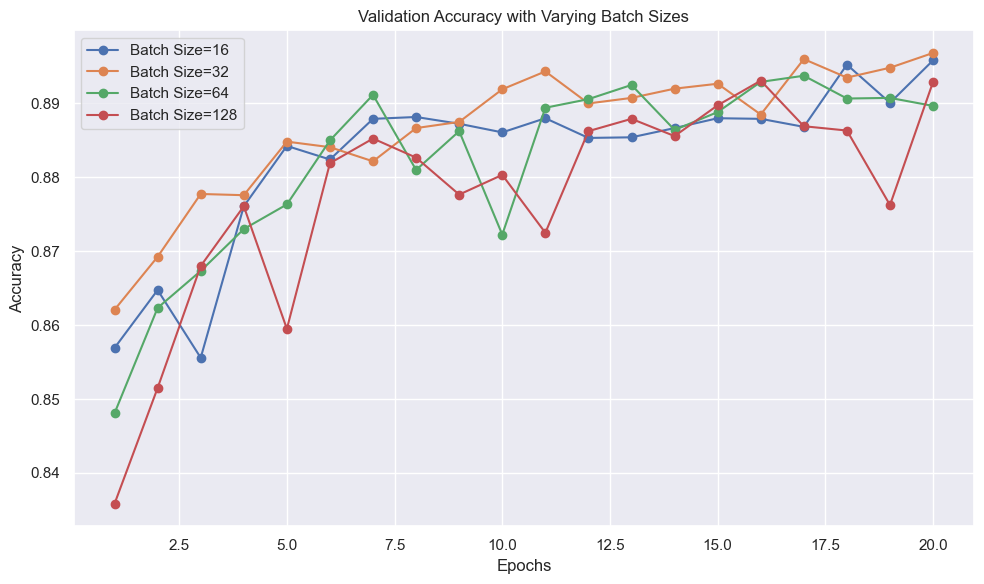

In [43]:
plt.figure(figsize=(10, 6))

for batch in batch_sizes:
    model = load_model(f'model_bs_{batch}')
    if model is None:
        continue
    epochs = range(1, len(model.val_accuracy_history) + 1)
    plt.plot(epochs, model.val_accuracy_history, marker='o', label=f'Batch Size={batch}')

plt.title('Validation Accuracy with Varying Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**: The best learning rate was 0.1, and the model performed optimally with a batch size of 64. We also chose to train all models for 20 epochs, since accuracy plateaued around this point during learning rate tuning, indicating that additional training offered minimal improvement.

In [44]:
# best_batch_size is located in task 1
best_lr = 0.05
best_epochs = 20

## 3.1: MLPs with Different Depths

### No Hidden Layers

No saved model found at saved_models\mlp1.1.pkl
Epoch 1/20, Loss: 0.6030, Train Accuracy: 0.7954, Test Accuracy: 0.8196
Epoch 2/20, Loss: 0.4923, Train Accuracy: 0.8337, Test Accuracy: 0.8250
Epoch 3/20, Loss: 0.4695, Train Accuracy: 0.8403, Test Accuracy: 0.8307
Epoch 4/20, Loss: 0.4540, Train Accuracy: 0.8451, Test Accuracy: 0.8342
Epoch 5/20, Loss: 0.4475, Train Accuracy: 0.8475, Test Accuracy: 0.8290
Epoch 6/20, Loss: 0.4374, Train Accuracy: 0.8506, Test Accuracy: 0.8311
Epoch 7/20, Loss: 0.4347, Train Accuracy: 0.8509, Test Accuracy: 0.8342
Epoch 8/20, Loss: 0.4323, Train Accuracy: 0.8526, Test Accuracy: 0.8291
Epoch 9/20, Loss: 0.4286, Train Accuracy: 0.8534, Test Accuracy: 0.8411
Epoch 10/20, Loss: 0.4239, Train Accuracy: 0.8551, Test Accuracy: 0.8381
Epoch 11/20, Loss: 0.4244, Train Accuracy: 0.8526, Test Accuracy: 0.8345
Epoch 12/20, Loss: 0.4221, Train Accuracy: 0.8552, Test Accuracy: 0.8362
Epoch 13/20, Loss: 0.4184, Train Accuracy: 0.8565, Test Accuracy: 0.8212
Epoch 14/20,

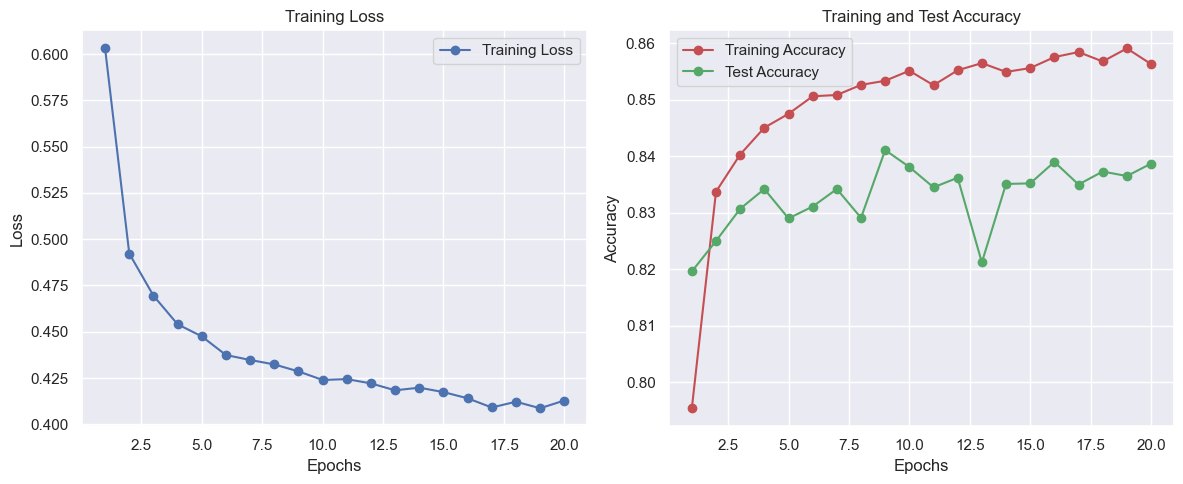

Model saved to saved_models\mlp1.1.pkl


In [47]:
# Model 1 - No hidden layers, ReLU activation
model1 = load_model('mlp1.1')
if model1 is None: 
    model1 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=0, units=[])
    model1.fit(train_loader, test_loader, best_lr, best_epochs) 
    model1.plot_history()
    save_model(model1, 'mlp1.1')
else: 
    model1.plot_history()

### One Hidden Layer

No saved model found at saved_models\mlp1.2.pkl
Epoch 1/20, Loss: 0.5050, Train Accuracy: 0.8208, Test Accuracy: 0.8442
Epoch 2/20, Loss: 0.3768, Train Accuracy: 0.8648, Test Accuracy: 0.8540
Epoch 3/20, Loss: 0.3379, Train Accuracy: 0.8779, Test Accuracy: 0.8653
Epoch 4/20, Loss: 0.3124, Train Accuracy: 0.8859, Test Accuracy: 0.8674
Epoch 5/20, Loss: 0.2919, Train Accuracy: 0.8942, Test Accuracy: 0.8755
Epoch 6/20, Loss: 0.2772, Train Accuracy: 0.8990, Test Accuracy: 0.8750
Epoch 7/20, Loss: 0.2625, Train Accuracy: 0.9049, Test Accuracy: 0.8781
Epoch 8/20, Loss: 0.2508, Train Accuracy: 0.9080, Test Accuracy: 0.8705
Epoch 9/20, Loss: 0.2389, Train Accuracy: 0.9133, Test Accuracy: 0.8750
Epoch 10/20, Loss: 0.2273, Train Accuracy: 0.9170, Test Accuracy: 0.8822
Epoch 11/20, Loss: 0.2177, Train Accuracy: 0.9196, Test Accuracy: 0.8778
Epoch 12/20, Loss: 0.2073, Train Accuracy: 0.9256, Test Accuracy: 0.8808
Epoch 13/20, Loss: 0.2001, Train Accuracy: 0.9276, Test Accuracy: 0.8801
Epoch 14/20,

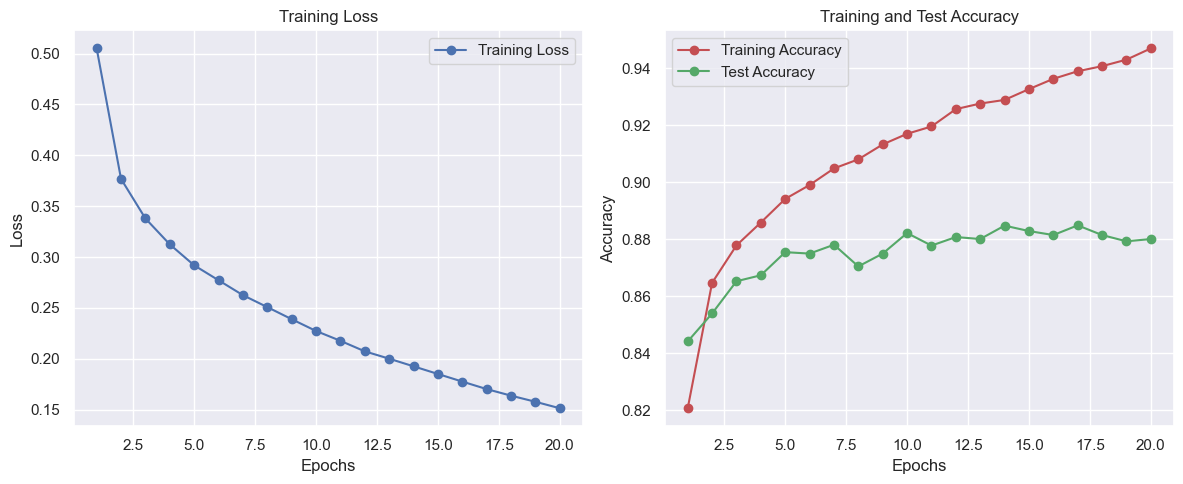

Model saved to saved_models\mlp1.2.pkl


In [48]:
# Model 2 - One hidden layer with 256 units, ReLU activation
model2 = load_model('mlp1.2')
if model2 is None: 
    model2 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=1, units=[256])
    model2.fit(train_loader, test_loader, best_lr, best_epochs) 
    model2.plot_history()
    save_model(model2, 'mlp1.2')
else: 
    model2.plot_history()

### Two Hidden Layers

No saved model found at saved_models\mlp1.3.pkl
Epoch 1/20, Loss: 0.4979, Train Accuracy: 0.8173, Test Accuracy: 0.8416
Epoch 2/20, Loss: 0.3627, Train Accuracy: 0.8662, Test Accuracy: 0.8572
Epoch 3/20, Loss: 0.3203, Train Accuracy: 0.8811, Test Accuracy: 0.8587
Epoch 4/20, Loss: 0.2945, Train Accuracy: 0.8907, Test Accuracy: 0.8677
Epoch 5/20, Loss: 0.2713, Train Accuracy: 0.8998, Test Accuracy: 0.8789
Epoch 6/20, Loss: 0.2521, Train Accuracy: 0.9058, Test Accuracy: 0.8733
Epoch 7/20, Loss: 0.2369, Train Accuracy: 0.9118, Test Accuracy: 0.8822
Epoch 8/20, Loss: 0.2229, Train Accuracy: 0.9172, Test Accuracy: 0.8807
Epoch 9/20, Loss: 0.2101, Train Accuracy: 0.9232, Test Accuracy: 0.8697
Epoch 10/20, Loss: 0.1973, Train Accuracy: 0.9268, Test Accuracy: 0.8721
Epoch 11/20, Loss: 0.1861, Train Accuracy: 0.9316, Test Accuracy: 0.8821
Epoch 12/20, Loss: 0.1772, Train Accuracy: 0.9357, Test Accuracy: 0.8815
Epoch 13/20, Loss: 0.1659, Train Accuracy: 0.9393, Test Accuracy: 0.8828
Epoch 14/20,

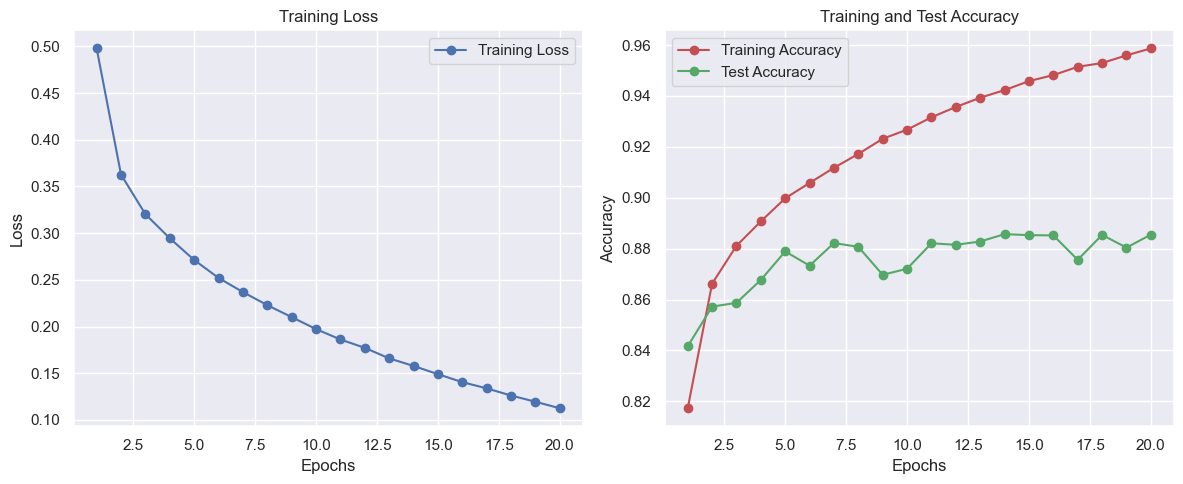

Model saved to saved_models\mlp1.3.pkl


In [84]:
# Model 3 - Two hidden layers with 256 units each, ReLU activation
model3 = load_model('mlp1.3')
if model3 is None: 
    model3 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model3.fit(train_loader, test_loader, best_lr, best_epochs) 
    model3.plot_history()
    save_model(model3, 'mlp1.3')
else: 
    model3.plot_history()

No saved model found at saved_models\mlp1.4.pkl
Epoch 1/20, Loss: 0.5033, Train Accuracy: 0.8164, Test Accuracy: 0.8447
Epoch 2/20, Loss: 0.3576, Train Accuracy: 0.8680, Test Accuracy: 0.8582
Epoch 3/20, Loss: 0.3157, Train Accuracy: 0.8827, Test Accuracy: 0.8675
Epoch 4/20, Loss: 0.2856, Train Accuracy: 0.8936, Test Accuracy: 0.8733
Epoch 5/20, Loss: 0.2633, Train Accuracy: 0.9025, Test Accuracy: 0.8775
Epoch 6/20, Loss: 0.2449, Train Accuracy: 0.9087, Test Accuracy: 0.8735
Epoch 7/20, Loss: 0.2266, Train Accuracy: 0.9150, Test Accuracy: 0.8770
Epoch 8/20, Loss: 0.2120, Train Accuracy: 0.9199, Test Accuracy: 0.8774
Epoch 9/20, Loss: 0.1983, Train Accuracy: 0.9255, Test Accuracy: 0.8797
Epoch 10/20, Loss: 0.1841, Train Accuracy: 0.9305, Test Accuracy: 0.8751
Epoch 11/20, Loss: 0.1727, Train Accuracy: 0.9361, Test Accuracy: 0.8807
Epoch 12/20, Loss: 0.1612, Train Accuracy: 0.9409, Test Accuracy: 0.8801
Epoch 13/20, Loss: 0.1510, Train Accuracy: 0.9435, Test Accuracy: 0.8832
Epoch 14/20,

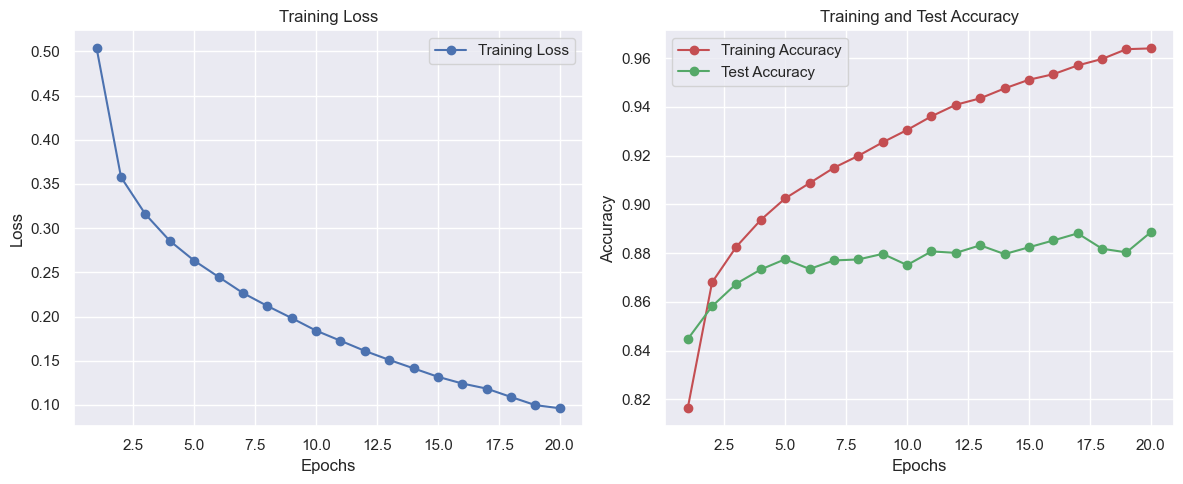

Model saved to saved_models\mlp1.4.pkl
No saved model found at saved_models\mlp1.5.pkl
Epoch 1/20, Loss: 0.5118, Train Accuracy: 0.8136, Test Accuracy: 0.8040
Epoch 2/20, Loss: 0.3589, Train Accuracy: 0.8676, Test Accuracy: 0.8543
Epoch 3/20, Loss: 0.3144, Train Accuracy: 0.8829, Test Accuracy: 0.8669
Epoch 4/20, Loss: 0.2854, Train Accuracy: 0.8921, Test Accuracy: 0.8729
Epoch 5/20, Loss: 0.2604, Train Accuracy: 0.9021, Test Accuracy: 0.8695
Epoch 6/20, Loss: 0.2425, Train Accuracy: 0.9091, Test Accuracy: 0.8772
Epoch 7/20, Loss: 0.2245, Train Accuracy: 0.9162, Test Accuracy: 0.8829
Epoch 8/20, Loss: 0.2097, Train Accuracy: 0.9203, Test Accuracy: 0.8717
Epoch 9/20, Loss: 0.1958, Train Accuracy: 0.9252, Test Accuracy: 0.8774
Epoch 10/20, Loss: 0.1826, Train Accuracy: 0.9316, Test Accuracy: 0.8773
Epoch 11/20, Loss: 0.1730, Train Accuracy: 0.9346, Test Accuracy: 0.8742
Epoch 12/20, Loss: 0.1604, Train Accuracy: 0.9401, Test Accuracy: 0.8789
Epoch 13/20, Loss: 0.1495, Train Accuracy: 0.9

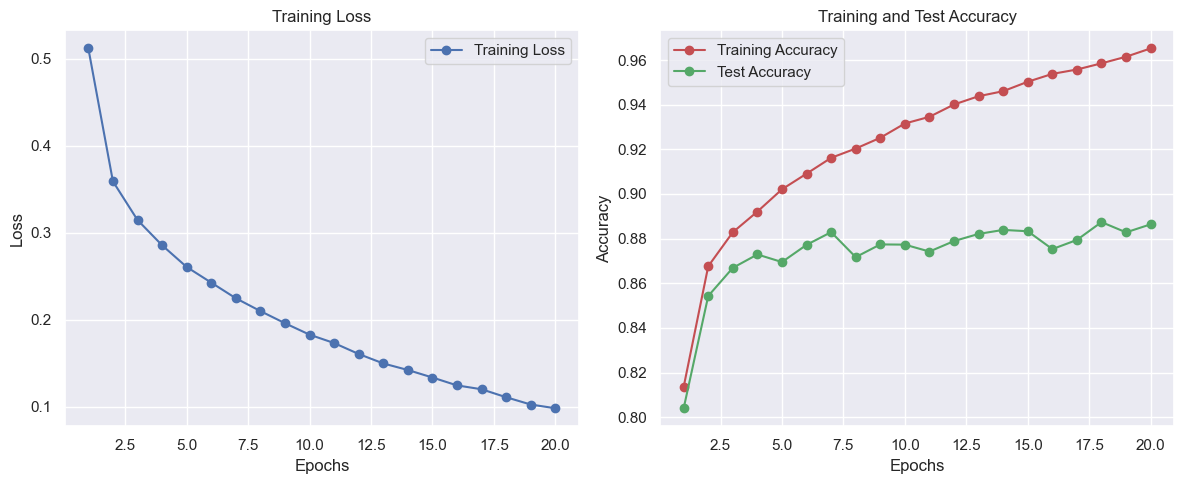

Model saved to saved_models\mlp1.5.pkl


In [52]:
# Additional models with more layers to explore the outcome of additional depth.
model4 = load_model('mlp1.4')
if model4 is None: 
    model4 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=3, units=[256,256,256])
    model4.fit(train_loader, test_loader, best_lr, best_epochs) 
    model4.plot_history()
    save_model(model4, 'mlp1.4')
model5 = load_model('mlp1.5')
if model5 is None: 
    model5 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=4, units=[256,256,256,256])
    model5.fit(train_loader, test_loader, best_lr, best_epochs) 
    model5.plot_history()
    save_model(model5, 'mlp1.5')

[np.float64(0.8196), np.float64(0.825), np.float64(0.8307), np.float64(0.8342), np.float64(0.829), np.float64(0.8311), np.float64(0.8342), np.float64(0.8291), np.float64(0.8411), np.float64(0.8381), np.float64(0.8345), np.float64(0.8362), np.float64(0.8212), np.float64(0.8351), np.float64(0.8352), np.float64(0.839), np.float64(0.835), np.float64(0.8373), np.float64(0.8365), np.float64(0.8387)]
[np.float64(0.8442), np.float64(0.854), np.float64(0.8653), np.float64(0.8674), np.float64(0.8755), np.float64(0.875), np.float64(0.8781), np.float64(0.8705), np.float64(0.875), np.float64(0.8822), np.float64(0.8778), np.float64(0.8808), np.float64(0.8801), np.float64(0.8848), np.float64(0.8829), np.float64(0.8815), np.float64(0.8849), np.float64(0.8815), np.float64(0.8793), np.float64(0.8801)]
[np.float64(0.8416), np.float64(0.8572), np.float64(0.8587), np.float64(0.8677), np.float64(0.8789), np.float64(0.8733), np.float64(0.8822), np.float64(0.8807), np.float64(0.8697), np.float64(0.8721), np.f

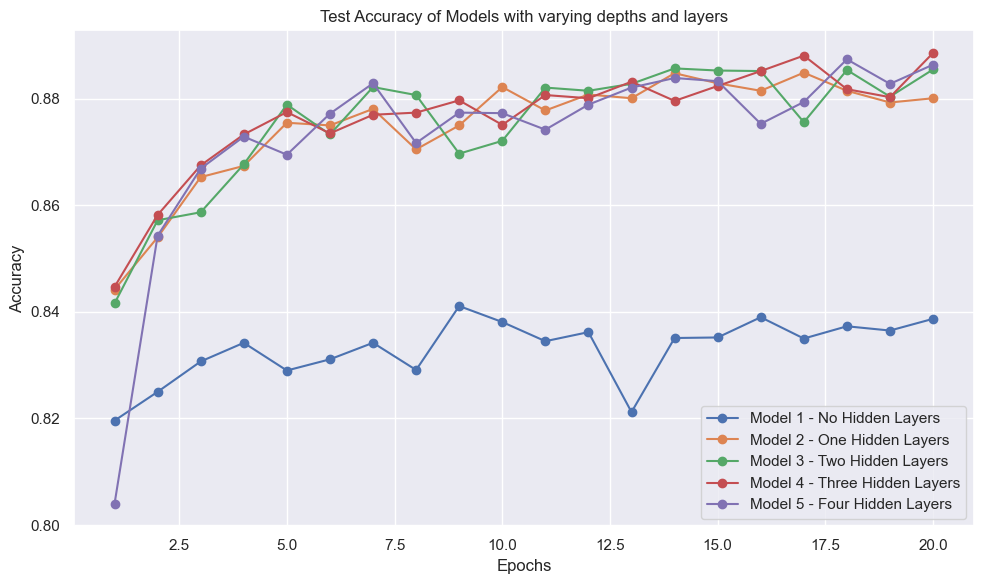

In [105]:
# Comparison of models test accuracy
models = [('Model 1 - No Hidden Layers', model1), ('Model 2 - One Hidden Layers', model2), ('Model 3 - Two Hidden Layers', model3), ('Model 4 - Three Hidden Layers', model4), ('Model 5 - Four Hidden Layers', model5)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    if model is None: 
        continue
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, model.test_accuracy_history, marker='o', label=model_name)
    print(model.test_accuracy_history)
plt.title('Test Accuracy of Models with varying depths and layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2: Activation Function Comparison

### Two Hidden Layers - Tanh Activation

No saved model found at saved_models\mlp2.1.pkl
Model loaded from saved_models\mlp1.3.pkl
Epoch 21/40, Loss: 0.2513, Train Accuracy: 0.9064, Test Accuracy: 0.8758
Epoch 22/40, Loss: 0.1738, Train Accuracy: 0.9370, Test Accuracy: 0.8817
Epoch 23/40, Loss: 0.1529, Train Accuracy: 0.9457, Test Accuracy: 0.8844
Epoch 24/40, Loss: 0.1429, Train Accuracy: 0.9489, Test Accuracy: 0.8834
Epoch 25/40, Loss: 0.1325, Train Accuracy: 0.9529, Test Accuracy: 0.8754
Epoch 26/40, Loss: 0.1255, Train Accuracy: 0.9554, Test Accuracy: 0.8780
Epoch 27/40, Loss: 0.1181, Train Accuracy: 0.9582, Test Accuracy: 0.8857
Epoch 28/40, Loss: 0.1098, Train Accuracy: 0.9611, Test Accuracy: 0.8863
Epoch 29/40, Loss: 0.1053, Train Accuracy: 0.9646, Test Accuracy: 0.8920
Epoch 30/40, Loss: 0.0996, Train Accuracy: 0.9654, Test Accuracy: 0.8896
Epoch 31/40, Loss: 0.0929, Train Accuracy: 0.9676, Test Accuracy: 0.8838
Epoch 32/40, Loss: 0.0900, Train Accuracy: 0.9691, Test Accuracy: 0.8882
Epoch 33/40, Loss: 0.0838, Train A

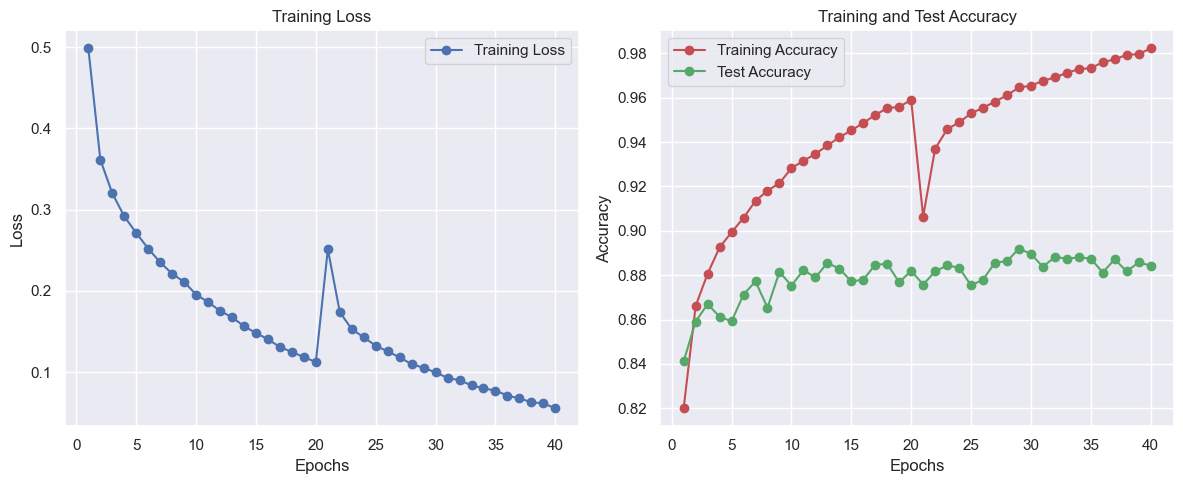

Model saved to saved_models\mlp2.1.pkl


In [53]:
# Copy of model with 2 hidden layers with tanh activation function
model3_tanh = load_model('mlp2.1')
if model3_tanh is None:
    model3_ReLU = load_model('mlp1.3')
    if model3_ReLU is not None: 
        model3_tanh = copy.deepcopy(model3_ReLU)
        model3_tanh.activation_function = tanh()
        model3_tanh.fit(train_loader, test_loader, best_lr, best_epochs)
        model3_tanh.plot_history()
        save_model(model3_tanh, 'mlp2.1')
else: 
    model3_tanh.plot_history()

### Two Hidden Layers - Leaky ReLU Activation

No saved model found at saved_models\mlp2.2.pkl
Model loaded from saved_models\mlp1.3.pkl
Epoch 21/40, Loss: 0.1047, Train Accuracy: 0.9625, Test Accuracy: 0.8880
Epoch 22/40, Loss: 0.0998, Train Accuracy: 0.9652, Test Accuracy: 0.8839
Epoch 23/40, Loss: 0.0951, Train Accuracy: 0.9656, Test Accuracy: 0.8851
Epoch 24/40, Loss: 0.0913, Train Accuracy: 0.9674, Test Accuracy: 0.8883
Epoch 25/40, Loss: 0.0837, Train Accuracy: 0.9702, Test Accuracy: 0.8839
Epoch 26/40, Loss: 0.0804, Train Accuracy: 0.9715, Test Accuracy: 0.8799
Epoch 27/40, Loss: 0.0750, Train Accuracy: 0.9743, Test Accuracy: 0.8882
Epoch 28/40, Loss: 0.0711, Train Accuracy: 0.9750, Test Accuracy: 0.8826
Epoch 29/40, Loss: 0.0664, Train Accuracy: 0.9771, Test Accuracy: 0.8830
Epoch 30/40, Loss: 0.0620, Train Accuracy: 0.9788, Test Accuracy: 0.8825
Epoch 31/40, Loss: 0.0599, Train Accuracy: 0.9789, Test Accuracy: 0.8856
Epoch 32/40, Loss: 0.0574, Train Accuracy: 0.9802, Test Accuracy: 0.8860
Epoch 33/40, Loss: 0.0525, Train A

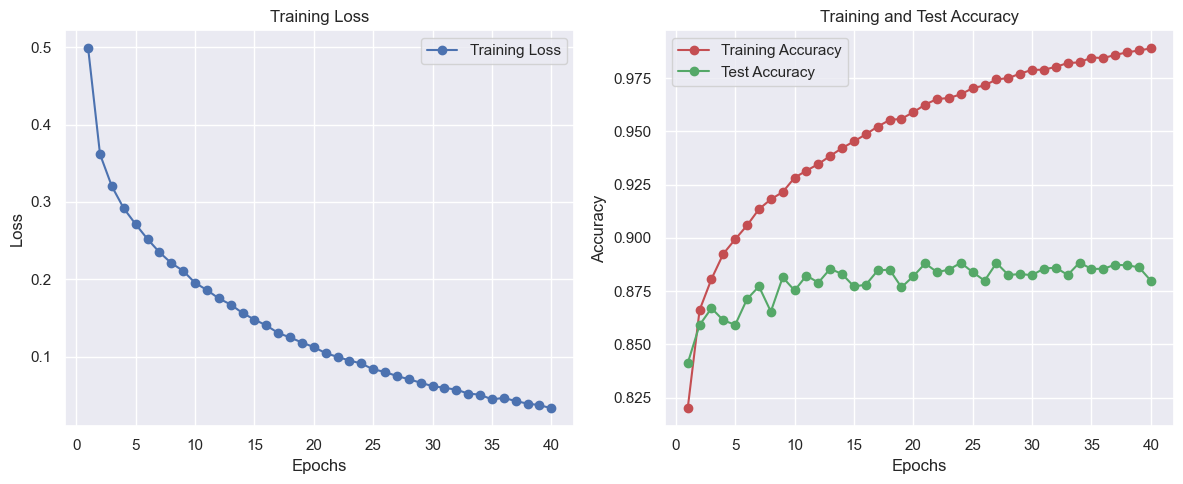

Model saved to saved_models\mlp2.2.pkl


In [54]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_leakyReLU = load_model('mlp2.2')
if model3_leakyReLU is None:
    model3_ReLU = load_model('mlp1.3')
    if model3_ReLU is not None: 
        model3_leakyReLU = copy.deepcopy(model3_ReLU)
        model3_leakyReLU.activation_function = leakyRelu()
        model3_leakyReLU.fit(train_loader, test_loader, best_lr, best_epochs)
        model3_leakyReLU.plot_history()
        save_model(model3_leakyReLU, 'mlp2.2')
else: 
    model3_leakyReLU.plot_history()

### Two Hidden Layers - Sigmoid

No saved model found at saved_models\mlp2.3.pkl
Model loaded from saved_models\mlp1.3.pkl
Epoch 21/40, Loss: 0.5512, Train Accuracy: 0.8385, Test Accuracy: 0.8374
Epoch 22/40, Loss: 0.3913, Train Accuracy: 0.8671, Test Accuracy: 0.8517
Epoch 23/40, Loss: 0.3523, Train Accuracy: 0.8778, Test Accuracy: 0.8596
Epoch 24/40, Loss: 0.3292, Train Accuracy: 0.8861, Test Accuracy: 0.8628
Epoch 25/40, Loss: 0.3122, Train Accuracy: 0.8916, Test Accuracy: 0.8608
Epoch 26/40, Loss: 0.2989, Train Accuracy: 0.8969, Test Accuracy: 0.8708
Epoch 27/40, Loss: 0.2876, Train Accuracy: 0.9001, Test Accuracy: 0.8710
Epoch 28/40, Loss: 0.2784, Train Accuracy: 0.9026, Test Accuracy: 0.8757
Epoch 29/40, Loss: 0.2690, Train Accuracy: 0.9054, Test Accuracy: 0.8774
Epoch 30/40, Loss: 0.2612, Train Accuracy: 0.9074, Test Accuracy: 0.8752
Epoch 31/40, Loss: 0.2535, Train Accuracy: 0.9103, Test Accuracy: 0.8790
Epoch 32/40, Loss: 0.2469, Train Accuracy: 0.9122, Test Accuracy: 0.8792
Epoch 33/40, Loss: 0.2404, Train A

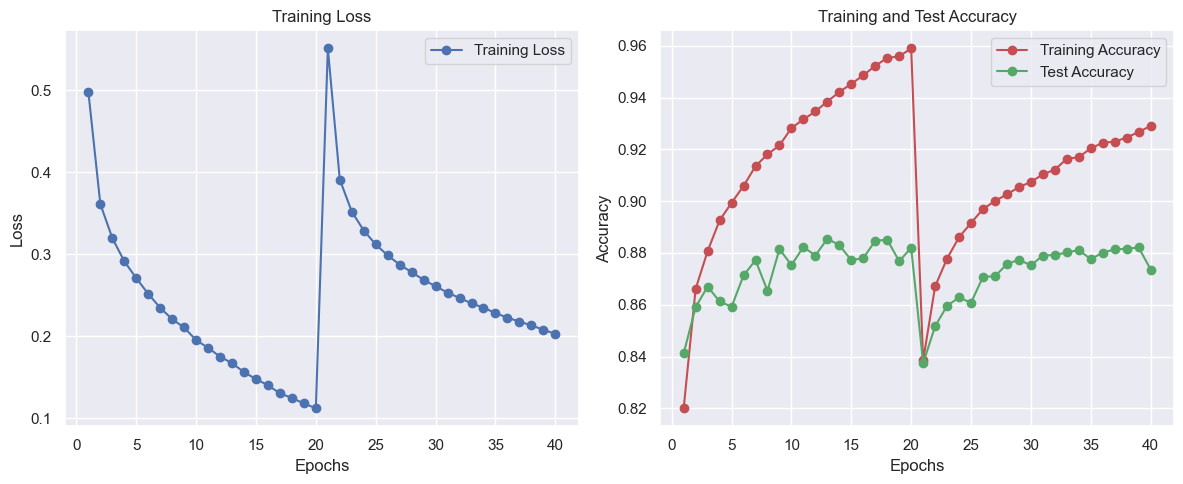

Model saved to saved_models\mlp2.3.pkl


In [69]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_sigmoid = load_model('mlp2.3')
if model3_sigmoid is None:
    model3_ReLU = load_model('mlp1.3')
    if model3_ReLU is not None: 
        model3_sigmoid = copy.deepcopy(model3_ReLU)
        model3_sigmoid.activation_function = sigmoid()
        model3_sigmoid.fit(train_loader, test_loader, best_lr, best_epochs)
        model3_sigmoid.plot_history()
        save_model(model3_sigmoid, 'mlp2.3')
else: 
    model3_sigmoid.plot_history()

### Two Hidden Layers - ReLU

No saved model found at saved_models\mlp2.4.pkl
Model loaded from saved_models\mlp1.3.pkl
Epoch 21/40, Loss: 0.1042, Train Accuracy: 0.9630, Test Accuracy: 0.8852
Epoch 22/40, Loss: 0.1002, Train Accuracy: 0.9642, Test Accuracy: 0.8823
Epoch 23/40, Loss: 0.0926, Train Accuracy: 0.9665, Test Accuracy: 0.8850
Epoch 24/40, Loss: 0.0883, Train Accuracy: 0.9690, Test Accuracy: 0.8829
Epoch 25/40, Loss: 0.0833, Train Accuracy: 0.9706, Test Accuracy: 0.8835
Epoch 26/40, Loss: 0.0794, Train Accuracy: 0.9709, Test Accuracy: 0.8883
Epoch 27/40, Loss: 0.0760, Train Accuracy: 0.9735, Test Accuracy: 0.8845
Epoch 28/40, Loss: 0.0695, Train Accuracy: 0.9764, Test Accuracy: 0.8819
Epoch 29/40, Loss: 0.0672, Train Accuracy: 0.9767, Test Accuracy: 0.8851
Epoch 30/40, Loss: 0.0630, Train Accuracy: 0.9782, Test Accuracy: 0.8800
Epoch 31/40, Loss: 0.0604, Train Accuracy: 0.9788, Test Accuracy: 0.8825
Epoch 32/40, Loss: 0.0567, Train Accuracy: 0.9804, Test Accuracy: 0.8866
Epoch 33/40, Loss: 0.0525, Train A

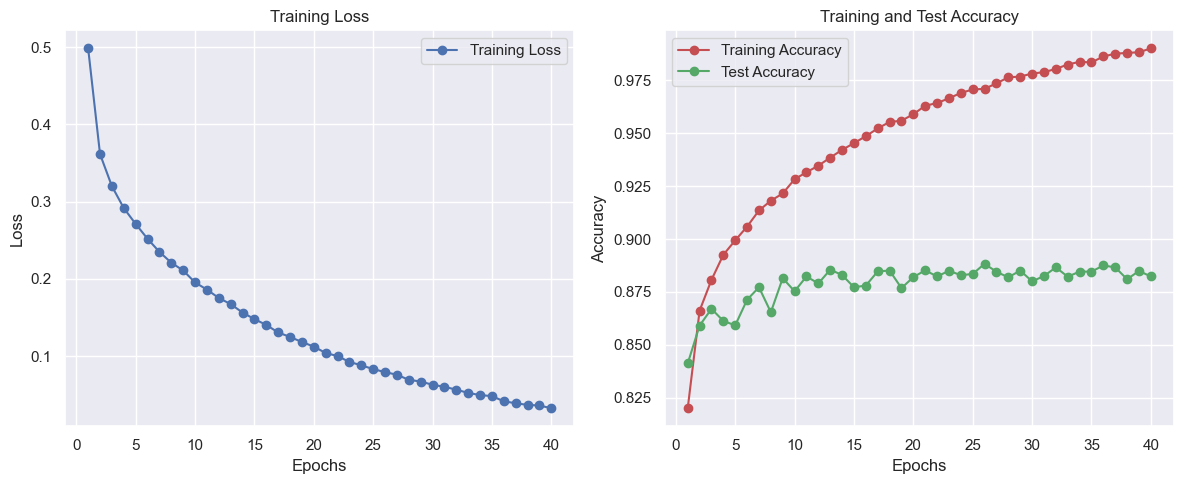

Model saved to saved_models\mlp2.4.pkl


In [56]:
# Retrain model with 2 hidden layers 20 more times
model3_ReLU_Extra = load_model('mlp2.4')
if model3_ReLU_Extra is None:
    model3_ReLU = load_model('mlp1.3')
    if model3_ReLU is not None: 
        model3_ReLU_Extra = copy.deepcopy(model3_ReLU)
        model3_ReLU_Extra.fit(train_loader, test_loader, best_lr, best_epochs)
        model3_ReLU_Extra.plot_history()
        save_model(model3_ReLU_Extra, 'mlp2.4')
else: 
    model3_ReLU_Extra.plot_history()

### Comparison

[np.float64(0.8412), np.float64(0.8591), np.float64(0.867), np.float64(0.8613), np.float64(0.8592), np.float64(0.8713), np.float64(0.8772), np.float64(0.8654), np.float64(0.8815), np.float64(0.8753), np.float64(0.8823), np.float64(0.879), np.float64(0.8855), np.float64(0.883), np.float64(0.8772), np.float64(0.878), np.float64(0.8847), np.float64(0.8851), np.float64(0.8768), np.float64(0.882), np.float64(0.8852), np.float64(0.8823), np.float64(0.885), np.float64(0.8829), np.float64(0.8835), np.float64(0.8883), np.float64(0.8845), np.float64(0.8819), np.float64(0.8851), np.float64(0.88), np.float64(0.8825), np.float64(0.8866), np.float64(0.8822), np.float64(0.8846), np.float64(0.8846), np.float64(0.8875), np.float64(0.8866), np.float64(0.881), np.float64(0.8849), np.float64(0.8823)]
[np.float64(0.8412), np.float64(0.8591), np.float64(0.867), np.float64(0.8613), np.float64(0.8592), np.float64(0.8713), np.float64(0.8772), np.float64(0.8654), np.float64(0.8815), np.float64(0.8753), np.float

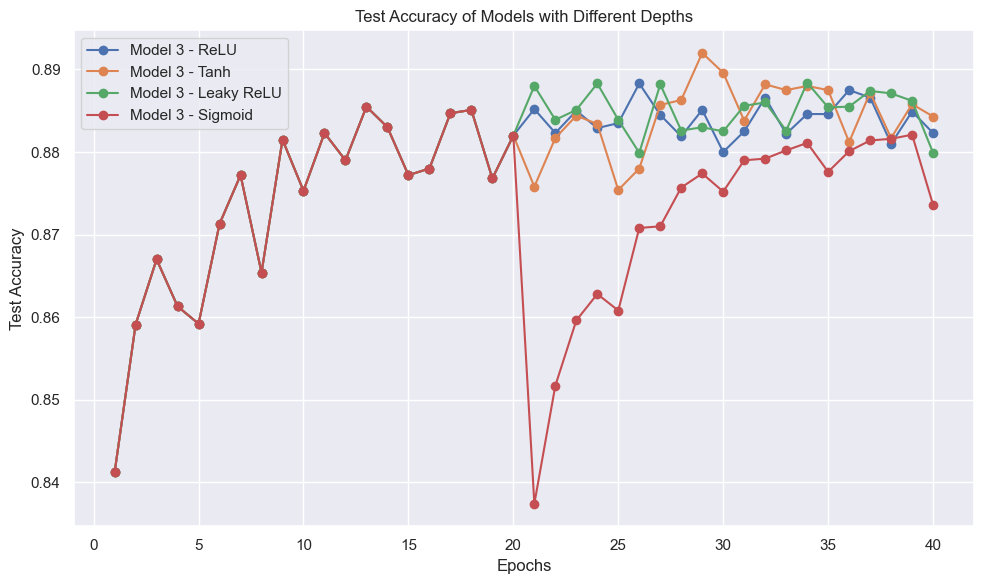

In [70]:
# Comparison of models test accuracy
models = [('Model 3 - ReLU', model3_ReLU_Extra), ('Model 3 - Tanh', model3_tanh), ('Model 3 - Leaky ReLU', model3_leakyReLU), ('Model 3 - Sigmoid', model3_sigmoid)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    if model is None: 
        continue
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, model.test_accuracy_history, marker='o', label=model_name)
    print(model.test_accuracy_history)
plt.title('Test Accuracy of Models with Different Depths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3: L1 and L2 Regularization

Model loaded from saved_models\model3_lambda1_0.0.pkl
[np.float64(0.8496), np.float64(0.8612), np.float64(0.8568), np.float64(0.8636), np.float64(0.8617), np.float64(0.8752), np.float64(0.8776), np.float64(0.8786), np.float64(0.8809), np.float64(0.8759)]
Model loaded from saved_models\model3_lambda1_0.0001.pkl
[np.float64(0.8449), np.float64(0.8592), np.float64(0.865), np.float64(0.8693), np.float64(0.872), np.float64(0.8743), np.float64(0.8789), np.float64(0.8764), np.float64(0.8683), np.float64(0.8772)]
Model loaded from saved_models\model3_lambda1_0.001.pkl
[np.float64(0.8376), np.float64(0.8526), np.float64(0.8637), np.float64(0.8622), np.float64(0.868), np.float64(0.8734), np.float64(0.8774), np.float64(0.8724), np.float64(0.8837), np.float64(0.8837)]
Model loaded from saved_models\model3_lambda1_0.01.pkl
[np.float64(0.8134), np.float64(0.8569), np.float64(0.8593), np.float64(0.8576), np.float64(0.8709), np.float64(0.8599), np.float64(0.8698), np.float64(0.8684), np.float64(0.8725

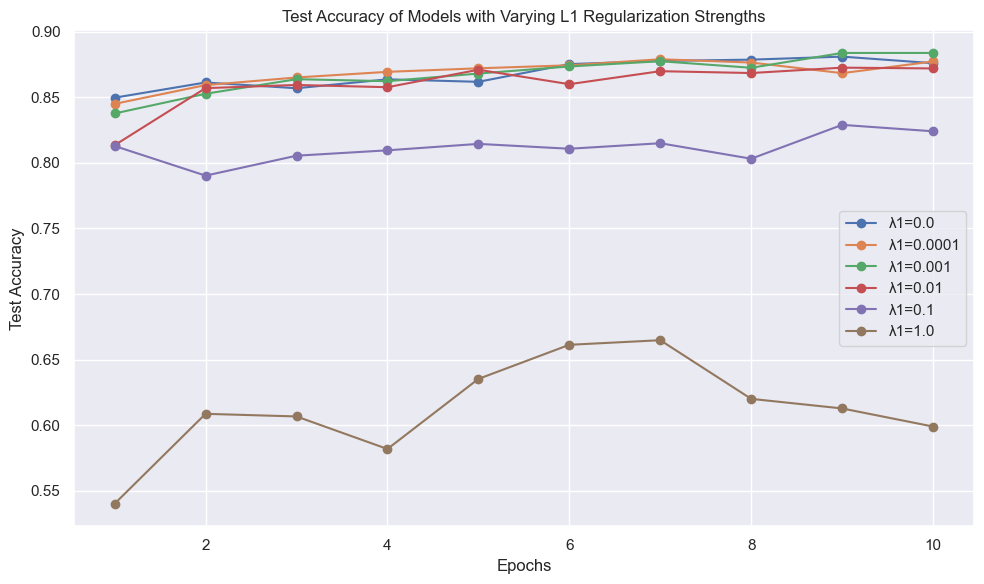

In [71]:
# Experimenting with L1 regularization strengths
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 5)))
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda1_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, best_lr, 10, lambda_l1=l)
        save_model(model, f'model3_lambda1_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), model.test_accuracy_history, marker='o', label=f'λ1={l}')
    print(model.test_accuracy_history)

plt.title('Test Accuracy of Models with Varying L1 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model loaded from saved_models\model3_lambda2_0.0.pkl
[np.float64(0.843), np.float64(0.8605), np.float64(0.8661), np.float64(0.8612), np.float64(0.8749), np.float64(0.8786), np.float64(0.8788), np.float64(0.8666), np.float64(0.8805), np.float64(0.8752)]
Model loaded from saved_models\model3_lambda2_0.0001.pkl
[np.float64(0.8407), np.float64(0.8558), np.float64(0.8615), np.float64(0.8674), np.float64(0.8631), np.float64(0.8758), np.float64(0.874), np.float64(0.8762), np.float64(0.8836), np.float64(0.8811)]
Model loaded from saved_models\model3_lambda2_0.001.pkl
[np.float64(0.8501), np.float64(0.8483), np.float64(0.8684), np.float64(0.8679), np.float64(0.8726), np.float64(0.8789), np.float64(0.8788), np.float64(0.8792), np.float64(0.8818), np.float64(0.8831)]
Model loaded from saved_models\model3_lambda2_0.01.pkl
[np.float64(0.8405), np.float64(0.8589), np.float64(0.8566), np.float64(0.8655), np.float64(0.8718), np.float64(0.877), np.float64(0.8794), np.float64(0.8814), np.float64(0.875)

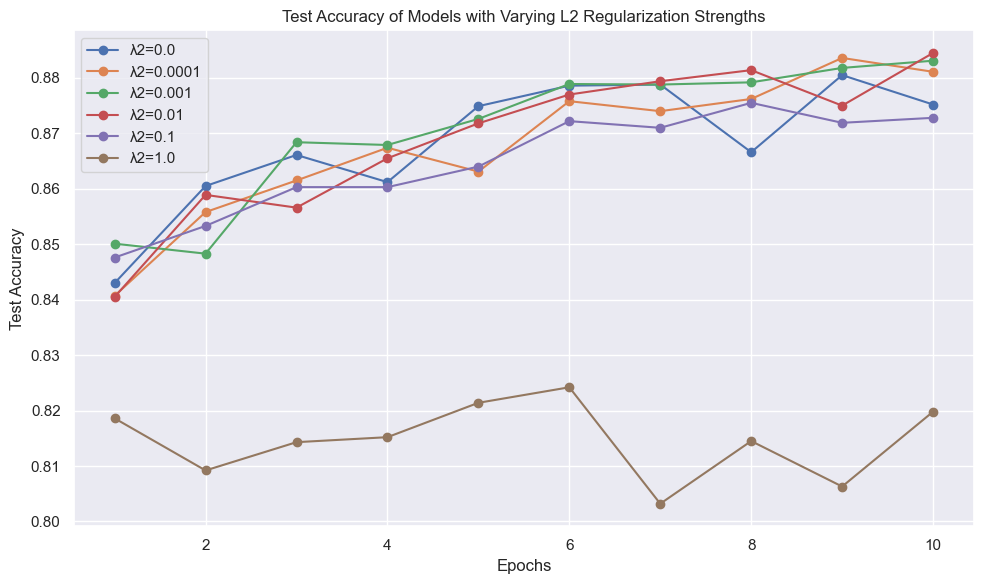

In [72]:
# Experimenting with L2 regularization strengths
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda2_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, best_lr, 10, lambda_l2=l)
        save_model(model, f'model3_lambda2_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), model.test_accuracy_history, marker='o', label=f'λ2={l}')
    print(model.test_accuracy_history)

plt.title('Test Accuracy of Models with Varying L2 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.4: Unnormalized Images

### Unnormalized Transformation

In [98]:
# Model with unnormalized images
mlp_transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.view(-1))
])
full_train_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_unnormalized)
test_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform_unnormalized)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_unnormalized))
val_size = len(full_train_dataset_unnormalized) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_unnormalized, val_dataset_unnormalized = random_split(full_train_dataset_unnormalized, [train_size, val_size], generator=generator)

# create dataloaders
train_loader_unnormalized = DataLoader(train_dataset_unnormalized, batch_size=best_batch_size, shuffle=True, generator=generator)
validation_loader_unnormalized = DataLoader(val_dataset_unnormalized, batch_size=best_batch_size, shuffle=False, generator=generator)
test_loader_unnormalized = DataLoader(test_dataset_unnormalized, batch_size=best_batch_size, shuffle=False, generator=generator)

### Load Models

In [99]:
# comparison of unnormalized model vs normalized model
model_unnormalized = load_model('mlp3.4_unnormalized')
model_normalized = load_model('mlp1.3')
if model_unnormalized is None: 
    model_unnormalized = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_unnormalized.fit(train_loader_unnormalized, test_loader_unnormalized, best_lr, best_epochs)
    save_model(model_unnormalized, 'mlp3.4_unnormalized')

Model loaded from saved_models\mlp3.4_unnormalized.pkl
Model loaded from saved_models\mlp1.3.pkl


### Plot Results

[np.float64(0.8146), np.float64(0.8353), np.float64(0.8499), np.float64(0.8494), np.float64(0.8494), np.float64(0.8654), np.float64(0.8738), np.float64(0.8579), np.float64(0.8621), np.float64(0.8722), np.float64(0.8716), np.float64(0.8773), np.float64(0.8797), np.float64(0.8748), np.float64(0.8652), np.float64(0.8833), np.float64(0.8818), np.float64(0.874), np.float64(0.884), np.float64(0.8779)]


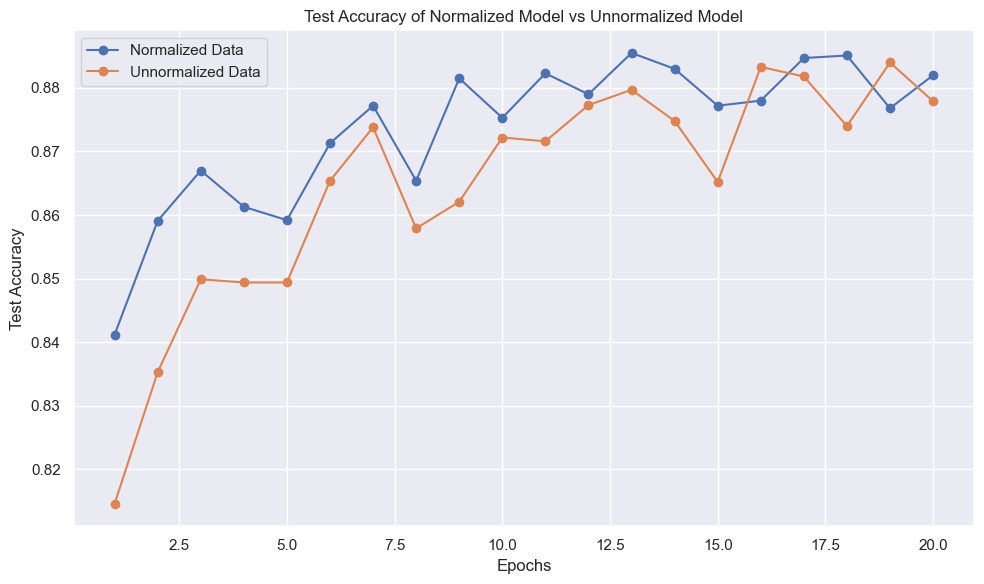

In [100]:
if model_unnormalized is None:
    raise ValueError("Normalized model not loaded properly.")

if model_normalized is None:
    raise ValueError("Augmented model not loaded properly.")
print(model_unnormalized.test_accuracy_history)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), model_normalized.test_accuracy_history, marker='o', label=f'Normalized Data')
plt.plot(range(1, len(model_unnormalized.test_accuracy_history) + 1),model_unnormalized.test_accuracy_history, marker='o', label=f'Unnormalized Data')
plt.title('Test Accuracy of Normalized Model vs Unnormalized Model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.5 MLP with Data Augmentation

### Data Augmentation Transformation

In [119]:
# Model with data augmentation (random horizontal flip and random rotation)
mlp_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
full_train_dataset_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_data_augmentation))
val_size = len(full_train_dataset_data_augmentation) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_data_augmentation, val_dataset_data_augmentation = random_split(full_train_dataset_data_augmentation, [train_size, val_size], generator=generator)

# create dataloader -- note that we use the same test_loader as before (no augmentation on test set)
train_loader_data_augmentation = DataLoader(train_dataset_data_augmentation, batch_size=best_batch_size, shuffle=True, generator=generator)

### Load Models

In [121]:
# comparison of augmented model vs normalized model
model_augmented = load_model('mlp3.5_augmented')
model_normalized = load_model('mlp1.3')

if model_augmented is None: 
    model_augmented = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_augmented.fit(train_loader_data_augmentation, test_loader, best_lr, best_epochs)
    save_model(model_augmented, 'mlp3.5_augmented')


No saved model found at saved_models\mlp3.5_augmented.pkl
Model loaded from saved_models\mlp1.3.pkl
Epoch 1/20, Loss: 0.6835, Train Accuracy: 0.7610, Test Accuracy: 0.5836
Epoch 2/20, Loss: 0.4860, Train Accuracy: 0.8248, Test Accuracy: 0.6161
Epoch 3/20, Loss: 0.4373, Train Accuracy: 0.8437, Test Accuracy: 0.6294
Epoch 4/20, Loss: 0.4088, Train Accuracy: 0.8530, Test Accuracy: 0.6290
Epoch 5/20, Loss: 0.3867, Train Accuracy: 0.8579, Test Accuracy: 0.6080
Epoch 6/20, Loss: 0.3712, Train Accuracy: 0.8652, Test Accuracy: 0.6306
Epoch 7/20, Loss: 0.3581, Train Accuracy: 0.8702, Test Accuracy: 0.6514
Epoch 8/20, Loss: 0.3474, Train Accuracy: 0.8728, Test Accuracy: 0.6229
Epoch 9/20, Loss: 0.3358, Train Accuracy: 0.8776, Test Accuracy: 0.6092
Epoch 10/20, Loss: 0.3284, Train Accuracy: 0.8793, Test Accuracy: 0.6134
Epoch 11/20, Loss: 0.3211, Train Accuracy: 0.8826, Test Accuracy: 0.5990
Epoch 12/20, Loss: 0.3138, Train Accuracy: 0.8854, Test Accuracy: 0.5973
Epoch 13/20, Loss: 0.3077, Train 

### Plot Results

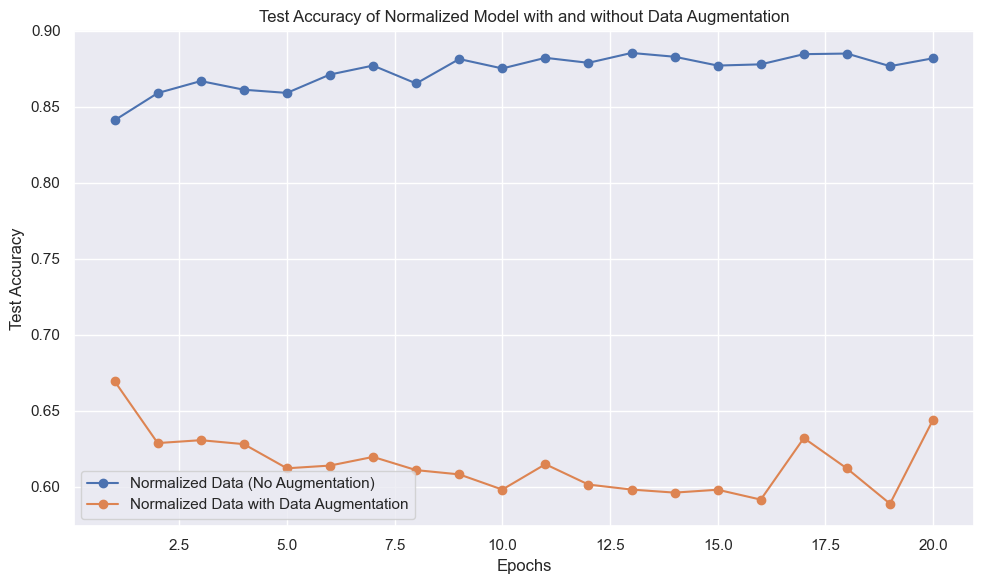

In [118]:
if model_normalized is None:
    raise ValueError("Normalized model not loaded properly.")

if model_augmented is None:
    raise ValueError("Augmented model not loaded properly.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), model_normalized.test_accuracy_history, marker='o', label=f'Normalized Data (No Augmentation)')
plt.plot(range(1, len(model_augmented.test_accuracy_history) + 1), model_augmented.test_accuracy_history, marker='o', label=f'Normalized Data with Data Augmentation')
plt.title('Test Accuracy of Normalized Model with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model_augmented = load_model('mlp3.5_augmented')
print(model_augmented.test_accuracy_history)  # type: ignore

Model loaded from saved_models/model3.5_augmented.pkl
[np.float64(0.7456), np.float64(0.8174), np.float64(0.815), np.float64(0.8273), np.float64(0.8348), np.float64(0.8358), np.float64(0.8364), np.float64(0.8439), np.float64(0.8509), np.float64(0.8518), np.float64(0.853), np.float64(0.8473), np.float64(0.8435), np.float64(0.8537), np.float64(0.8565), np.float64(0.8611), np.float64(0.856), np.float64(0.8583), np.float64(0.8618), np.float64(0.8644)]


## 3.6: CNN Using Pytorch

### CNN-specific Data Transformation

In [5]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


### CCN Class

In [12]:
## Import CNN implementation from cnn.py
import cnn                
importlib.reload(cnn)     # reloads the module from disk
from cnn import CNN

# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### CNN Hyperparameter Tuning

#### Learning Rates

In [8]:
# comparison of learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

# Initialize empty DataFrame
columns = ["LR", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()

for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')

    if cnn_model is None:
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_lr_{lr}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[lr, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl
      LR  Validation Loss  Validation Accuracy
0  0.001         0.467081             0.922167
1  0.005         0.491892             0.893500
2  0.010         0.385755             0.878583
3  0.050         2.311386             0.098667
4  0.100         2.308781             0.096500


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl


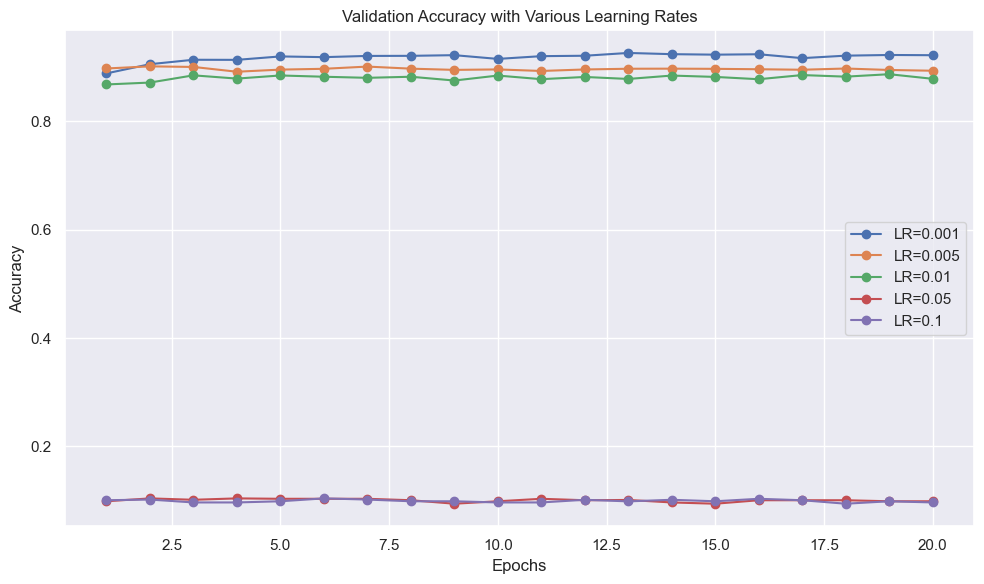

In [ ]:
plt.figure(figsize=(10, 6))
clipped_lrs = [0.001, 0.005, 0.01]
for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'LR={lr}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl


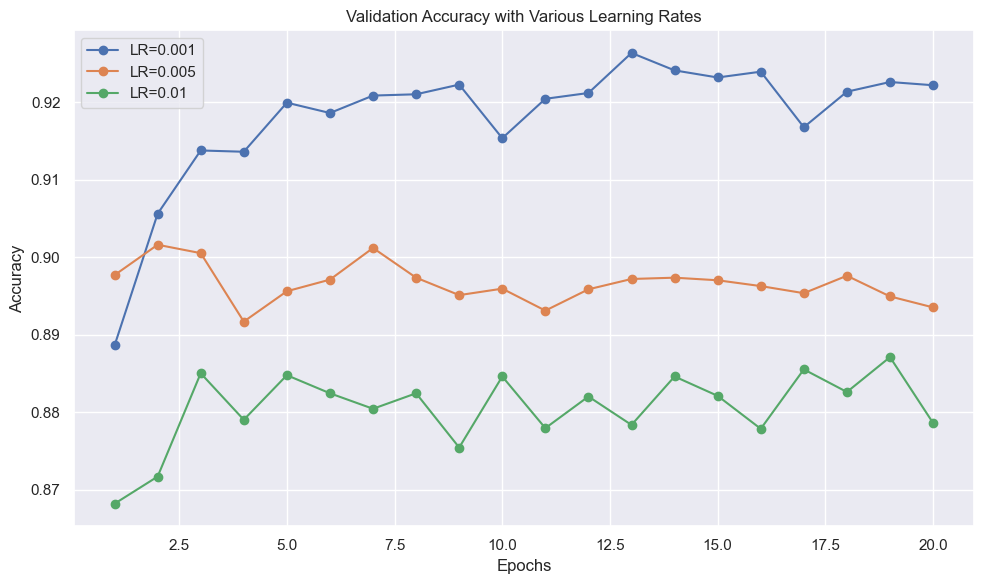

In [10]:
plt.figure(figsize=(10, 6))
clipped_lrs = [0.001, 0.005, 0.01]
for lr in clipped_lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'LR={lr}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [23]:
acc_matrix = {}

for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue

    # Each LR becomes a row
    acc_matrix[lr] = {epoch+1: acc for epoch, acc in enumerate(cnn_model.val_accuracies_cnn)}

# Convert into a dataframe with rows = LRs, cols = Epochs
df = pd.DataFrame.from_dict(acc_matrix, orient='index')

df.index.name = "Learning Rate"
df.columns.name = "Epoch"

display(df)


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl


Epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Learning Rate,,,,,,,,,,,,,,,,,,,,
0.001,0.888583,0.905583,0.913750,0.913583,0.919917,0.918583,0.920833,0.921000,0.922250,0.915333,0.920417,0.921167,0.926333,0.924083,0.923167,0.923917,0.916750,0.921333,0.922583,0.922167
0.005,0.897667,0.901583,0.900500,0.891667,0.895583,0.897083,0.901167,0.897333,0.895083,0.895917,0.893083,0.895833,0.897167,0.897333,0.897000,0.896250,0.895333,0.897583,0.894917,0.893500
0.010,0.868167,0.871667,0.885000,0.879000,0.884750,0.882417,0.880417,0.882417,0.875417,0.884583,0.877917,0.882000,0.878333,0.884583,0.882083,0.877833,0.885500,0.882583,0.887083,0.878583
0.050,0.098667,0.104000,0.101417,0.104000,0.103250,0.103250,0.103250,0.100583,0.094167,0.098667,0.103250,0.100583,0.101083,0.096500,0.094167,0.100583,0.100583,0.100583,0.098667,0.098667
0.100,0.100583,0.101833,0.096500,0.096500,0.098667,0.104000,0.101833,0.098667,0.098667,0.096500,0.096500,0.101417,0.098500,0.101417,0.098667,0.103250,0.100583,0.094167,0.098667,0.096500


#### Batch size

In [25]:
# create dataloaders
batch_sizes = [32, 64, 128]

# Initialize empty DataFrame
columns = ["Batch Size", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()


for batch_size in batch_sizes:
    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

    cnn_model = load_model(f'cnn_model_batch_{batch_size}')

    if cnn_model is None:
        learning_rate = 0.001
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_batch_{batch_size}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[batch_size, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl
   Batch Size  Validation Loss  Validation Accuracy
0          32         0.567449             0.919083
1          64         0.512745             0.920833
2         128         0.394224             0.920083


Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl


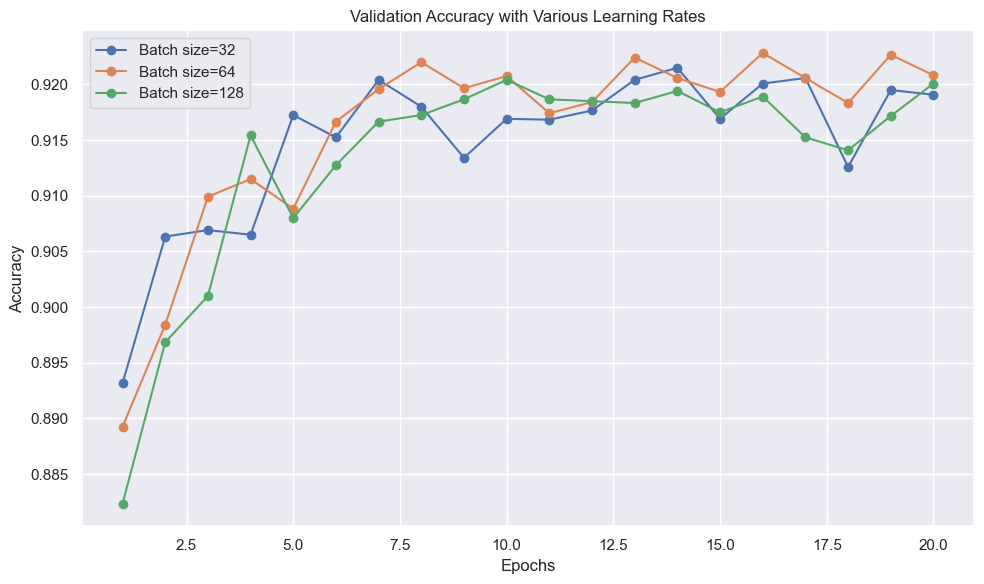

In [ ]:
plt.figure(figsize=(10, 6))

for batch_size in batch_sizes:
    cnn_model = load_model(f'cnn_model_batch_{batch_size}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'Batch size={batch_size}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [27]:
acc_matrix = {}

for batch_size in batch_sizes:
    cnn_model = load_model(f'cnn_model_batch_{batch_size}')
    if cnn_model is None:
        continue

    # Each Batch Size becomes a row
    acc_matrix[batch_size] = {epoch+1: acc for epoch, acc in enumerate(cnn_model.val_accuracies_cnn)}

# Convert into a dataframe with rows = Batch Size, cols = Epochs
df = pd.DataFrame.from_dict(acc_matrix, orient='index')

df.index.name = "Batch Size"
df.columns.name = "Epoch"

display(df)

Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl


Epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Batch Size,,,,,,,,,,,,,,,,,,,,
32,0.893167,0.906333,0.906917,0.906500,0.917250,0.915250,0.920417,0.91800,0.913417,0.916917,0.916833,0.917667,0.920417,0.921500,0.916917,0.920083,0.920583,0.912583,0.919500,0.919083
64,0.889250,0.898417,0.909917,0.911500,0.908833,0.916667,0.919583,0.92200,0.919667,0.920750,0.917417,0.918417,0.922417,0.920583,0.919333,0.922833,0.920583,0.918333,0.922667,0.920833
128,0.882333,0.896833,0.901000,0.915417,0.908000,0.912750,0.916667,0.91725,0.918667,0.920417,0.918667,0.918500,0.918333,0.919417,0.917500,0.918917,0.915250,0.914083,0.917167,0.920083


In [ ]:
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
cnn = load_model('cnn_model_batch_64')
save_model(cnn, 'cnn_model_tuned')

Model loaded from saved_models/cnn_model_batch_64.pkl
Model saved to saved_models/cnn_model_tuned.pkl


### CNN Initialization and Training

In [ ]:
# Initialize CNN model and train
cnn = load_model('cnn_model_tuned')
if cnn is None: 
    learning_rate = 0.001
    cnn = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn, 'cnn_model_tuned')


Model loaded from saved_models/cnn_model_tuned.pkl


### Plot results

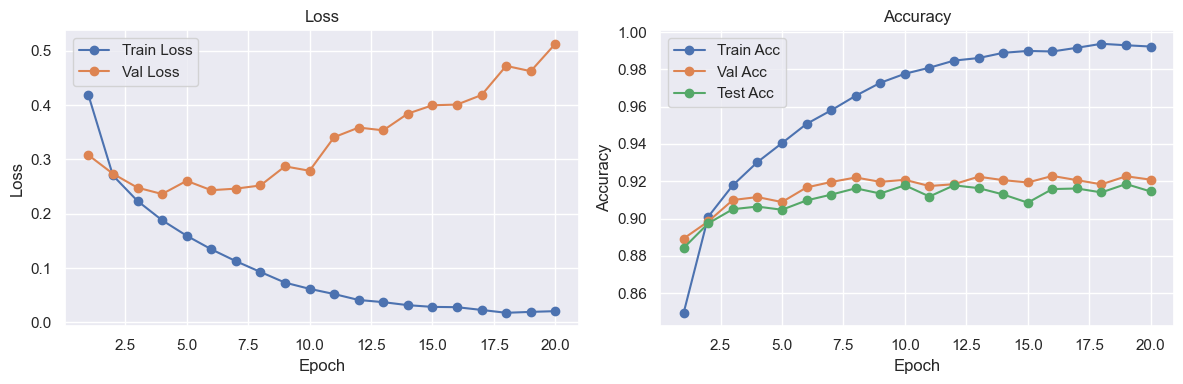

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn,'o-', label='Train Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


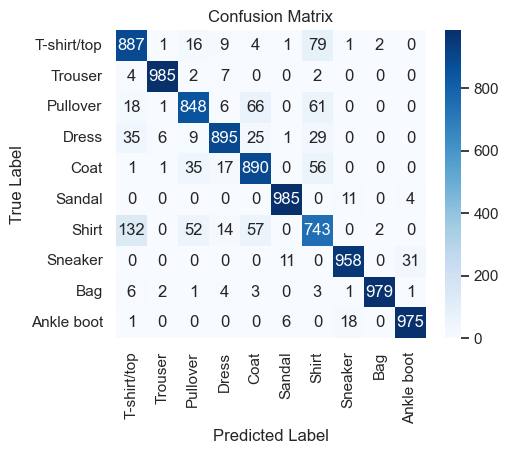

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7: CNN with Data Augmentation

In [ ]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, _ = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)

### CCN with data augmentation Initialization and Training

In [14]:
# Initialize CNN model with data augmentation and train
cnn_aug = load_model('cnn_model_tuned_augmented')
if cnn_aug is None:
    learning_rate = 0.001
    cnn_aug = CNN().to(device)
    optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn_aug.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn_aug, 'cnn_model_tuned_augmented')

Model loaded from saved_models/cnn_model_tuned_augmented.pkl


Model loaded from saved_models/cnn_model_tuned.pkl
Model loaded from saved_models/cnn_model_tuned_augmented.pkl


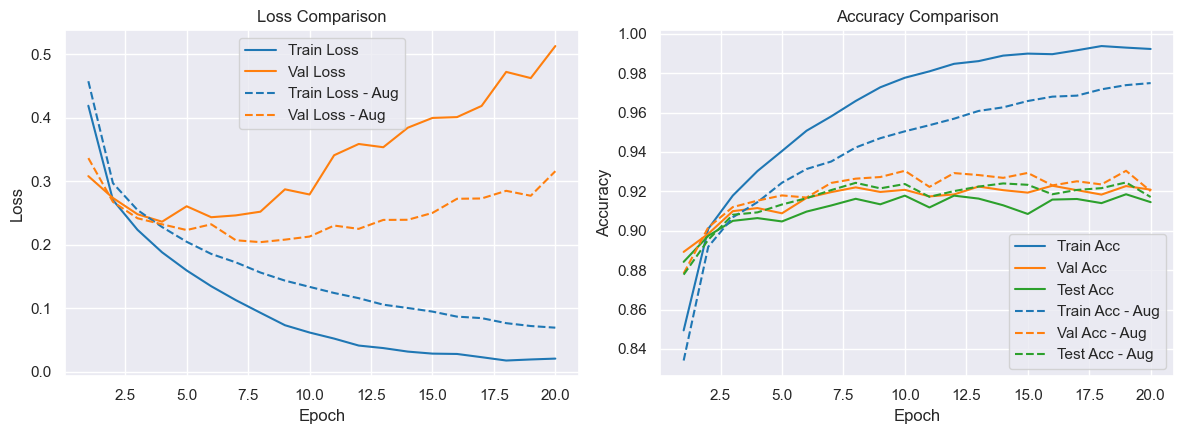

Training time without augmentation: 184.60 seconds
Training time with augmentation: 207.87 seconds


In [48]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,4.5))
colors = ['tab:blue', 'tab:orange', 'tab:green']

cnn = load_model('cnn_model_tuned')
cnn_aug = load_model('cnn_model_tuned_augmented')

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

if cnn_aug is None:
    raise ValueError("CNN_Aug model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, label='Train Loss', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, label='Val Loss', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_losses_cnn, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_losses_cnn, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn, label='Train Acc', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, label='Val Acc', color=colors[1])
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, label='Test Acc', color=colors[2])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_accuracies_cnn, label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_accuracies_cnn, label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.test_accuracies_cnn, label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {cnn.train_time:.2f} seconds")
print(f"Training time with augmentation: {cnn_aug.train_time:.2f} seconds")

In [49]:
cnn = load_model('cnn_model_tuned')
cnn_aug = load_model('cnn_model_tuned_augmented')

if cnn is None or cnn_aug is None:
    raise ValueError("Model not loaded")

df = pd.DataFrame({
    "Epoch": list(range(1, 21)),
    "CNN Val Loss": cnn.val_losses_cnn,
    "CNN Test Acc": cnn.test_accuracies_cnn, 
    "CNN Aug Val Loss": cnn_aug.val_losses_cnn,
    "CNN Aug Test Acc": cnn_aug.test_accuracies_cnn
})

display(df)

# Find maximum accuracy and minimum loss for all four columns
cnn_val_loss_min_idx = df['CNN Val Loss'].idxmin()
cnn_val_loss_min_epoch = df.loc[cnn_val_loss_min_idx, 'Epoch']
cnn_val_loss_min = df.loc[cnn_val_loss_min_idx, 'CNN Val Loss']

cnn_test_acc_max_idx = df['CNN Test Acc'].idxmax()
cnn_test_acc_max_epoch = df.loc[cnn_test_acc_max_idx, 'Epoch']
cnn_test_acc_max = df.loc[cnn_test_acc_max_idx, 'CNN Test Acc']

cnn_aug_val_loss_min_idx = df['CNN Aug Val Loss'].idxmin()
cnn_aug_val_loss_min_epoch = df.loc[cnn_aug_val_loss_min_idx, 'Epoch']
cnn_aug_val_loss_min = df.loc[cnn_aug_val_loss_min_idx, 'CNN Aug Val Loss']

cnn_aug_test_acc_max_idx = df['CNN Aug Test Acc'].idxmax()
cnn_aug_test_acc_max_epoch = df.loc[cnn_aug_test_acc_max_idx, 'Epoch']
cnn_aug_test_acc_max = df.loc[cnn_aug_test_acc_max_idx, 'CNN Aug Test Acc']

print(f"\nMaximum accuracy and minimum loss:")
print(f"CNN Val Loss - Epoch: {cnn_val_loss_min_epoch}, Min value: {cnn_val_loss_min:.4f}")
print(f"CNN Test Acc - Epoch: {cnn_test_acc_max_epoch}, Max value: {cnn_test_acc_max:.4f}")
print(f"CNN Aug Val Loss - Epoch: {cnn_aug_val_loss_min_epoch}, Min value: {cnn_aug_val_loss_min:.4f}")
print(f"CNN Aug Test Acc - Epoch: {cnn_aug_test_acc_max_epoch}, Max value: {cnn_aug_test_acc_max:.4f}")

Model loaded from saved_models/cnn_model_tuned.pkl
Model loaded from saved_models/cnn_model_tuned_augmented.pkl


,Epoch,CNN Val Loss,CNN Test Acc,CNN Aug Val Loss,CNN Aug Test Acc
0,1,0.307962,0.8842,0.336356,0.8777
1,2,0.273615,0.8974,0.267486,0.8954
2,3,0.247970,0.9050,0.241665,0.9081
3,4,0.236272,0.9064,0.232139,0.9093
4,5,0.260539,0.9047,0.223099,0.9133
5,6,0.243298,0.9097,0.232164,0.9165
6,7,0.246177,0.9128,0.207030,0.9206
7,8,0.252004,0.9162,0.204065,0.9243
8,9,0.287194,0.9134,0.208007,0.9215
9,10,0.279074,0.9178,0.212844,0.9237



Maximum accuracy and minimum loss:
CNN Val Loss - Epoch: 4, Min value: 0.2363
CNN Test Acc - Epoch: 19, Max value: 0.9185
CNN Aug Val Loss - Epoch: 8, Min value: 0.2041
CNN Aug Test Acc - Epoch: 19, Max value: 0.9245


## 3.8: Pretrained ResNet 

### Load ResNet18

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchinfo import summary
# Load a pre-trained ResNet-18 model
ResNet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

### Prepare ResNet18 for Modification

In [ ]:
# Freeze all convolutional layers
for param in ResNet18.parameters():
    param.requires_grad = False

# Modify First Layer for Grayscale Input
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layers (fc layer)
ResNet18.fc = nn.Identity() # Replace fc with identity # type: ignore
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11     

### Custom ResNet18 Class

In [ ]:
import custom_ResNet
importlib.reload(custom_ResNet)     # reloads the module from disk
from custom_ResNet import CustomResNet18  # rebinds names in notebook namespace

In [ ]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### Hyperparameter Tuning

#### One layer added

In [ ]:
# Initialize CNN model and train
custom_resnet18_one_layers =  None #load_model('cnn_ResNet18_1_layers')
if custom_resnet18_one_layers is None: 
    learning_rate = 0.001
    num_classes = 10
    fc_layer = nn.Sequential(
        nn.Linear(512, num_classes)  # ResNet18's last feature map has 512 channels
    )
    custom_resnet18_one_layers = CustomResNet18(ResNet18, fc_layer).to(device)
    optimizer = optim.Adam(custom_resnet18_one_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_one_layers.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_one_layers, 'cnn_ResNet18_1_layers')

summary(custom_resnet18_one_layers)

Epoch 1/20: Train loss=1.0713, Train acc=62.40%, Val loss=0.8134, Val acc=70.89%, Test acc=71.28%
Epoch 2/20: Train loss=0.8075, Train acc=70.79%, Val loss=0.7001, Val acc=74.98%, Test acc=74.27%
Epoch 3/20: Train loss=0.7477, Train acc=72.94%, Val loss=0.6824, Val acc=75.94%, Test acc=75.89%
Epoch 4/20: Train loss=0.7222, Train acc=73.83%, Val loss=0.6714, Val acc=75.83%, Test acc=75.56%
Epoch 5/20: Train loss=0.7044, Train acc=74.58%, Val loss=0.6488, Val acc=76.12%, Test acc=75.92%
Epoch 6/20: Train loss=0.7024, Train acc=74.70%, Val loss=0.6502, Val acc=75.76%, Test acc=76.32%
Epoch 7/20: Train loss=0.6887, Train acc=75.01%, Val loss=0.6196, Val acc=77.80%, Test acc=77.09%
Epoch 8/20: Train loss=0.6747, Train acc=75.68%, Val loss=0.6022, Val acc=78.30%, Test acc=77.95%
Epoch 9/20: Train loss=0.6645, Train acc=75.90%, Val loss=0.6080, Val acc=77.76%, Test acc=77.71%
Epoch 10/20: Train loss=0.6582, Train acc=76.42%, Val loss=0.5849, Val acc=78.56%, Test acc=78.83%
Epoch 11/20: Train 

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

#### Two layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_two_layers = load_model('cnn_ResNet18_2_layers')
if custom_resnet18_two_layers is None: 
    learning_rate = 0.001
    fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    custom_resnet18_two_layers = CustomResNet18(ResNet18, fc_layers).to(device)
    optimizer = optim.Adam(custom_resnet18_two_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_two_layers, 'cnn_ResNet18_2_layers')
else:
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_two_layers, 'cnn_ResNet18_2_layers')

summary(custom_resnet18_two_layers)

Model loaded from saved_models/cnn_ResNet18_2_layers.pkl
Epoch 11/20: Train loss=0.5221, Train acc=80.66%, Val loss=0.5030, Val acc=81.71%, Test acc=81.43%
Epoch 12/20: Train loss=0.5270, Train acc=80.52%, Val loss=0.4996, Val acc=81.62%, Test acc=81.56%
Epoch 13/20: Train loss=0.5300, Train acc=80.49%, Val loss=0.5026, Val acc=81.73%, Test acc=81.54%
Epoch 14/20: Train loss=0.5313, Train acc=80.30%, Val loss=0.5004, Val acc=81.70%, Test acc=81.53%
Epoch 15/20: Train loss=0.5303, Train acc=80.43%, Val loss=0.4991, Val acc=81.62%, Test acc=81.89%
Epoch 16/20: Train loss=0.5265, Train acc=80.59%, Val loss=0.5054, Val acc=81.63%, Test acc=81.52%
Epoch 17/20: Train loss=0.5285, Train acc=80.50%, Val loss=0.5027, Val acc=81.43%, Test acc=81.30%
Epoch 18/20: Train loss=0.5305, Train acc=80.28%, Val loss=0.5024, Val acc=81.72%, Test acc=81.30%
Epoch 19/20: Train loss=0.5233, Train acc=80.63%, Val loss=0.5002, Val acc=81.67%, Test acc=81.58%
Epoch 20/20: Train loss=0.5282, Train acc=80.41%, Va

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

#### Three layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_three_layers = None # load_model('cnn_ResNet18_3_layers')
if custom_resnet18_three_layers is None: 
    learning_rate = 0.001
    fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, 128),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    custom_resnet18_three_layers = CustomResNet18(ResNet18, fc_layers).to(device)
    optimizer = optim.Adam(custom_resnet18_three_layers.parameters(), lr=learning_rate)
    
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_three_layers.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_three_layers, 'cnn_ResNet18_3_layers')

summary(custom_resnet18_three_layers)

Epoch 1/20: Train loss=0.7125, Train acc=74.70%, Val loss=0.5624, Val acc=79.70%, Test acc=79.04%
Epoch 2/20: Train loss=0.6143, Train acc=77.59%, Val loss=0.5620, Val acc=79.89%, Test acc=79.62%
Epoch 3/20: Train loss=0.5901, Train acc=78.48%, Val loss=0.5466, Val acc=80.29%, Test acc=80.12%
Epoch 4/20: Train loss=0.5821, Train acc=78.56%, Val loss=0.5210, Val acc=80.94%, Test acc=80.37%
Epoch 5/20: Train loss=0.5679, Train acc=79.00%, Val loss=0.5416, Val acc=79.96%, Test acc=79.53%
Epoch 6/20: Train loss=0.5570, Train acc=79.55%, Val loss=0.5161, Val acc=81.47%, Test acc=80.94%
Epoch 7/20: Train loss=0.5546, Train acc=79.73%, Val loss=0.5064, Val acc=81.85%, Test acc=81.19%
Epoch 8/20: Train loss=0.5463, Train acc=80.00%, Val loss=0.5148, Val acc=80.98%, Test acc=80.89%
Epoch 9/20: Train loss=0.5391, Train acc=80.04%, Val loss=0.5133, Val acc=81.28%, Test acc=81.38%
Epoch 10/20: Train loss=0.5291, Train acc=80.47%, Val loss=0.5117, Val acc=81.15%, Test acc=80.94%
Epoch 11/20: Train 

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Layer Comparison

Model loaded from saved_models/cnn_ResNet18_1_layers.pkl
Model loaded from saved_models/cnn_ResNet18_2_layers.pkl
Model loaded from saved_models/cnn_ResNet18_3_layers.pkl


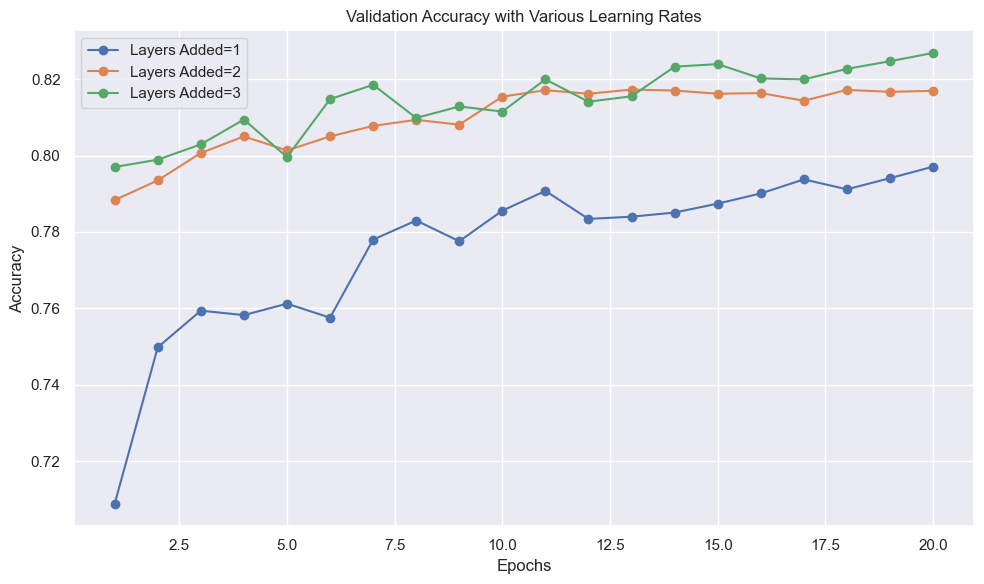

In [52]:
plt.figure(figsize=(10, 6))
layers = [1,2,3]
for layer in layers:
    resnet_model = load_model(f'cnn_ResNet18_{layer}_layers')
    if resnet_model is None:
        continue
    epochs = range(1, len(resnet_model.val_losses_cnn) + 1)
    plt.plot(epochs, resnet_model.val_accuracies_cnn, marker='o', label=f'Layers Added={layer}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [56]:
acc_matrix = {}
layers = [1,2,3]
for layer in layers:
    resnet_model = load_model(f'cnn_ResNet18_{layer}_layers')
    if resnet_model is None:
        continue

    # Each Batch Size becomes a row
    acc_matrix[layer] = {epoch+1: acc for epoch, acc in enumerate(resnet_model.val_accuracies_cnn)}

# Convert into a dataframe with rows = Batch Size, cols = Epochs
df = pd.DataFrame.from_dict(acc_matrix, orient='index')

df.index.name = "Added Layers"
df.columns.name = "Epoch"

display(df)

Model loaded from saved_models/cnn_ResNet18_1_layers.pkl
Model loaded from saved_models/cnn_ResNet18_2_layers.pkl
Model loaded from saved_models/cnn_ResNet18_3_layers.pkl


Epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Added Layers,,,,,,,,,,,,,,,,,,,,
1,0.708917,0.749833,0.759417,0.758250,0.761250,0.757583,0.77800,0.783000,0.777583,0.785583,0.790750,0.783417,0.78400,0.785083,0.787417,0.790083,0.793750,0.791167,0.794083,0.797083
2,0.788333,0.793500,0.800667,0.805000,0.801333,0.805000,0.80775,0.809333,0.808083,0.815417,0.817083,0.816167,0.81725,0.817000,0.816167,0.816333,0.814333,0.817167,0.816667,0.816917
3,0.797000,0.798917,0.802917,0.809417,0.799583,0.814750,0.81850,0.809833,0.812833,0.811500,0.819917,0.814083,0.81550,0.823250,0.823917,0.820167,0.819917,0.822667,0.824667,0.826833


### Plot Results

Model loaded from saved_models/cnn_ResNet18_3_layers.pkl


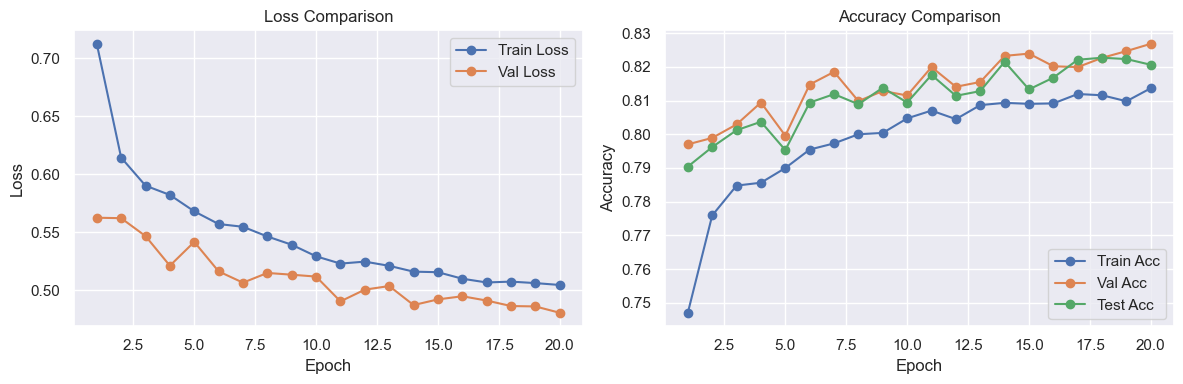

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

resnet_model = load_model(f'cnn_ResNet18_3_layers')
if resnet_model is None:
    raise ValueError("resnet_model model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.train_accuracies_cnn, 'o-', label='Train Acc')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [53]:
resnet_model = load_model(f'cnn_ResNet18_3_layers')
print(resnet_model.test_accuracies_cnn)  # type: ignore

Model loaded from saved_models/cnn_ResNet18_3_layers.pkl
[0.7904, 0.7962, 0.8012, 0.8037, 0.7953, 0.8094, 0.8119, 0.8089, 0.8138, 0.8094, 0.8176, 0.8114, 0.8128, 0.8215, 0.8133, 0.8168, 0.8221, 0.8227, 0.8223, 0.8206]


### Results Confusion Matrix

(10, 10)


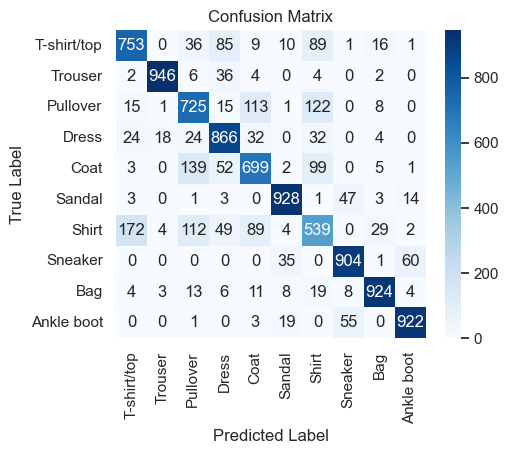

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if resnet_model is None:
    raise ValueError("resnet_model model not loaded properly.")

resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = resnet_model(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()